## Análisis de Dataset 

In [1]:
# Data Manipulation & Visualization
import os
import pandas as pd
import numpy as np
import seaborn as sns
#sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import pickle as pk
from scipy import sparse as sp
import copy

!pip install pyLDAvis
# Text Manipulation
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import gensim
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,mean_squared_error,mean_absolute_error,log_loss,accuracy_score,classification_report
from sklearn.metrics import precision_score
#import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#from sklearn import feature_extraction, linear_model, model_selection, preprocessing

     |████████████████████████████████| 1.6MB 13.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=5871dd8f5430fe7635b1eedb51fa89b420240452ee40850f7ad893bd85a6bd4b
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [2]:
#importamos el dataframe 
df = pd.read_csv('https://github.com/pokengineer/rawdata/blob/main/tripadvisor_hotel_reviews.csv?raw=true')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


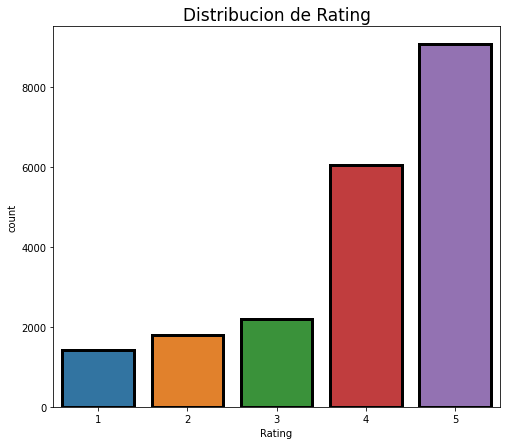

In [3]:
#visualizamos el dataframe
plt.figure(figsize=(8,7))
sns.countplot(data=df,x="Rating",edgecolor='black',linewidth=3)
plt.title('Distribucion de Rating',size=17)
plt.show()

podemos ver que el dataset esta desbalanceado, tenemos muchas más reseñas de 4-5 estrellas que reseñas negativas. Esto afectará nuestra capacidad de predecir reseñas negativas.

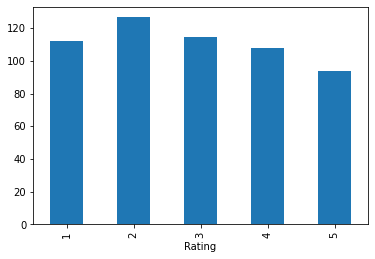

In [4]:
#contemos la cantidad de palabras
df2 = copy.copy(df)
df2['cant'] = df['Review'].str.split().str.len()
df2.groupby("Rating")['cant'].mean().plot(kind='bar')

In [5]:
df2.corr()

,Rating,cant
Rating,1.000000,-0.090674
cant,-0.090674,1.000000


Podemos ver que la cantidad de palabras promedio no es un indicador fuerte para nada, por lo que necesitaremos estrategias de **Minería de texto** que generen mejores indicadores que conteos de palabras y/o variables dummies

## Modelo LDA
Para generar el modelo preditivo utilizaremos varias bibliotecas diferentes.
  * genism para el pre-procesamiento del texto y la clusterizacion de palabras por temas
  * xgboost biblioteca utilizada para aplicar gradient boost
  * sklearn la biblioteca estudiada en la materia para generar modelos redictivos (en este estudio utilizaremos pipeline)

### Pre-Procesamiento de texto
Importamos la biblioteca nltk (Natural Language Toolkit), que contiene un set de herramientas que nos permitiran analizar texto de forma más interesante

In [ ]:
docs= np.array(df['Review'])

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\facuv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower() 
        docs[idx] = tokenizer.tokenize(docs[idx])  # lo separamos en palabras (tokens).

    # Eliminamos los numeros de la lista de tokens.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Eliminamos los tokens con solo un caracter
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Hallamos el Lema correspondiente a cada token (proceso de Lematización)
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

docs = docs_preprocessor(docs)


In [ ]:
# Generamos los bigramas y trigramas
# Los bigramas son utilizados comúnmente como base para el simple análisis estadístico de texto.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # es bigrama
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # es bigrama
            docs[idx].append(token)

  En orden las operaciones realizadas fueron:
  * Eliminamos Números
  * Eliminamos letras individuales
  * Lematizamos
  * Agregamos Bigramas
  * Agregamos Trigramas

In [ ]:
# Creamos un diccionario con los tokens de docs.
dictionary = Dictionary(docs)
print('Cantidad de palabras distintas en el diccionario:', len(dictionary))

# filtramos las palabras que aparezcan menos de 10 veces o en más del 20% del documento
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Cantidad de palabtas distintas luego de remover las más raras y las más comunes:', len(dictionary))

Cantidad de palabras distintas en el diccionario: 52086
Cantidad de palabtas distintas luego de remover las más raras y las más comunes: 12057


In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Cantidad de tokens únicos: %d' % len(dictionary))
print('Cantidad de documentos: %d' % len(corpus))

Cantidad de tokens únicos: 12057
Cantidad de documentos: 20491


### Entrenamiento

In [ ]:
# Seteamos los parametros.
num_topics = 10
chunksize = 500
passes = 20 
iterations = 400
eval_every = 1 # si esto es más de uno toma mucho más tiempo 

# Cargamos el diccionario con los tokens obtenidos y armamos el modelo LDA
temp = dictionary[0] 
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every,random_state=12)

CPU times: user 6min 6s, sys: 287 ms, total: 6min 6s
Wall time: 6min 6s


In [ ]:
pyLDAvis.gensim.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.048241 -0.140995       1        1  20.648193
6      0.122910 -0.066691       2        1  16.975655
2      0.149678 -0.066952       3        1  15.178820
4     -0.105596 -0.176366       4        1  13.728435
1      0.250048  0.019264       5        1   7.957857
8      0.053974 -0.021699       6        1   6.621609
5     -0.223021 -0.018398       7        1   6.453463
0     -0.291461 -0.080469       8        1   5.113053
3      0.095828  0.156577       9        1   4.054234
7     -0.100600  0.395729      10        1   3.268680, topic_info=                    Term         Freq        Total Category  logprob  loglift
5104               beach  9910.000000  9910.000000  Default  30.0000  30.0000
5066              resort  8860.000000  8860.000000  Default  29.0000  29.0000
48                review  4790.000000  4790.000000  Default  28.0000  28.0000
341       staff_friendly  6251.000000  6251.000000  Default  27.0000  27.0000
2043         minute_walk  5011.000000  5011.000000  Default  26.0000  26.0000
...                  ...          ...          ...      ...      ...      ...
1724  dinner_reservation   324.623467   439.072478  Topic10  -5.2155   3.1188
304                water   491.948642  5338.881797  Topic10  -4.7998   1.0364
84                bottle   335.490875  1232.683955  Topic10  -5.1826   2.1194
466                glass   319.221754  1184.867375  Topic10  -5.2323   2.1093
347                 wine   285.657666  1190.488757  Topic10  -5.3434   1.9935

[545 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1517      1  0.040174   absolutely
1517      2  0.279209   absolutely
1517      3  0.073652   absolutely
1517      4  0.018748   absolutely
1517      6  0.587879   absolutely
...     ...       ...          ...
857       6  0.281426         year
6772     10  0.998606   you__ç_éèe
691       1  0.041158        young
691       5  0.958388        young
8598      5  0.999319  young_child

[1049 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 3, 5, 2, 9, 6, 1, 4, 8])

In [ ]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [ ]:
# vemos los temas en los que el modelo separo los tokens
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(model,topic_number=i, topn=5, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]

term                 frequency

Topic 0 |---------------------

flat_screen          0.016
barcelona            0.016
euro                 0.015
breakfast_buffet     0.014
modern               0.014
Topic 1 |---------------------

make                 0.024
make_sure            0.018
sure                 0.018
ocean                0.011
train_station        0.011
Topic 2 |---------------------

desk                 0.012
check                0.012
told                 0.009
problem              0.009
asked                0.009
Topic 3 |---------------------

review               0.057
read_review          0.019
trip_advisor         0.019
read                 0.018
swimming_pool        0.017
Topic 4 |---------------------

staff_friendly       0.023
minute_walk          0.020
comfortable          0.015
city                 0.014
station              0.013
Topic 5 |---------------------

free                 0.021
internet             0.018
coffee               0.017
free_internet       

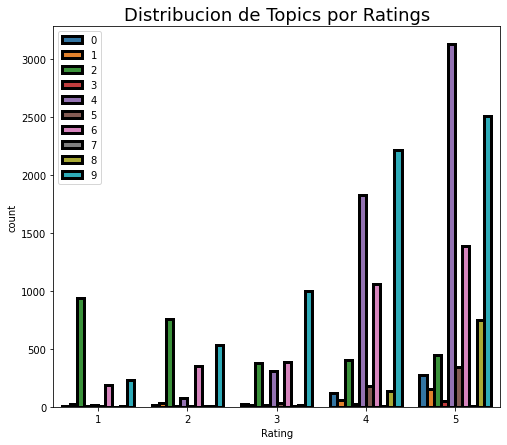

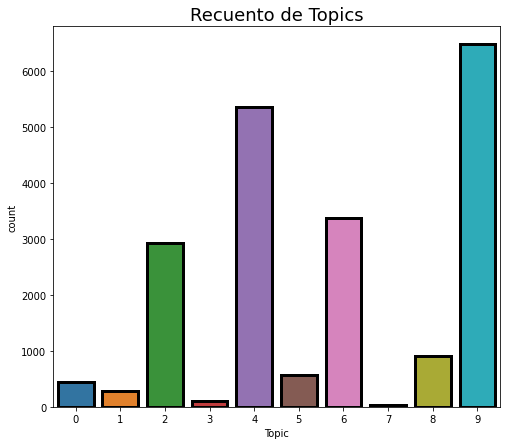

In [ ]:
# agregamos los temas como una columna del dataframe
all_topics = model.get_document_topics(corpus, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
df['Topic'] = all_topics_numpy.argmax(axis=1)

# graficamos la Distribucion de Topics por Ratings
plt.figure(figsize=(8,7))
sns.countplot(data=df,x="Rating",hue="Topic",edgecolor="black",linewidth=3)
plt.legend(['0','1','2','3','4','5','6','7','8','9'])
plt.title('Distribucion de Topics por Ratings',size=18)
plt.show()

# graficamos el recuento de topicos
plt.figure(figsize=(8,7))
ax=sns.countplot(data=df,x="Topic",edgecolor="black",linewidth=3)
ax.set_xticklabels(['0','1','2','3','4','5','6','7','8','9'])
plt.title('Recuento de Topics',size=18)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X = df['Review']
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
xgb = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier(objective="multi:softmax",n_estimators=300,learning_rate=0.01))
              ])

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

              precision    recall  f1-score   support

           1       0.31      0.71      0.43       126
           2       0.07      0.49      0.13        49
           3       0.07      0.47      0.12        64
           4       0.32      0.43      0.37       930
           5       0.90      0.55      0.68      2930

    accuracy                           0.53      4099
   macro avg       0.33      0.53      0.35      4099
weighted avg       0.73      0.53      0.59      4099



Accuracy: 0.525738
Weighted Precision :0.727017
MAE (error absoluto promedio):0.749939
RMSE (error cuadrado promedio):1.264294


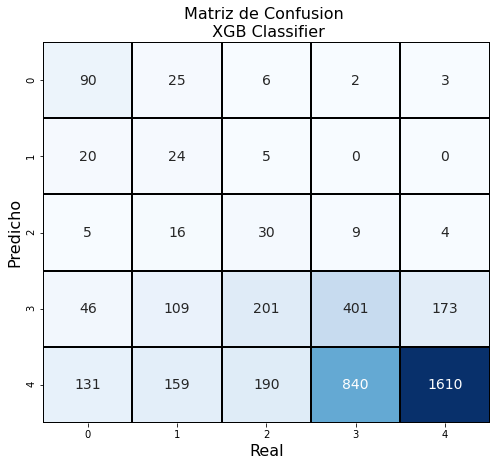

In [ ]:
print(classification_report(y_pred,y_test,zero_division=0))
print("\n")
print("Accuracy: %f" % accuracy_score(y_pred,y_test))
print("Weighted Precision :%f" % precision_score(y_pred,y_test,average="weighted"))
print("MAE (error absoluto promedio):%f" % mean_absolute_error(y_pred,y_test))
print("RMSE (error cuadrado promedio):%f" % mean_squared_error(y_pred,y_test,squared=False))


plt.figure(figsize=(8,7))
cm=confusion_matrix(y_pred,y_test)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Blues',cbar=False)

plt.xlabel('Real',size=16)
plt.ylabel('Predicho',size=16)
plt.title('Matriz de Confusion \n XGB Classifier',size=16)
plt.show()

Nos interesa de esa matriz la diagonal principal, ya que estos serán los aciertos del modelo. Podemos ver que como el dataset estaba desbalanceado y la mayoria de las reseñas eran positivas, el modelo consiguio una mayor precisión para predecir reseñas positivas.\
Notamos viendo las dos primeras filas que en la mayoria de los casos que el modelo predijo 1 o 2 estrellas acerto (un alto valor de recall) pero viendo las primeras dos columnas vemos que tembien clasifico erroneamente muchas reseñas como 4 o 5 estrellas cuando en realidad eran 1 o 2 (bajo valor de precision).





### GridSearch

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time
import logging

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}


In [ ]:
model = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier(objective="multi:softmax",n_estimators=300,learning_rate=0.01))
              ])
gs = GridSearchCV(model, 
                  parameters, 
                  cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=1), #Cross Validation de 3 capas
                  verbose=1,
                  n_jobs=-1)
gs.fit(X_train, y_train)

# Mostramos los mejores resultados obtenidos

print(gs.best_estimator_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 77.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 163.9min finished


[16:14:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_iter, penalty } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Pipeline(steps=[('vect', TfidfVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 XGBClassifier(alpha=1e-06, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=6, max_iter=20,
                               min_child_weight=1, missing=nan,
           

In [ ]:
y_pred = gs.best_estimator_.predict(X_test)

_________________________Classification Report_________________________
              precision    recall  f1-score   support

           1       0.39      0.68      0.49       166
           2       0.21      0.41      0.28       168
           3       0.11      0.46      0.18       104
           4       0.39      0.46      0.42      1051
           5       0.87      0.60      0.71      2610

    accuracy                           0.55      4099
   macro avg       0.39      0.52      0.42      4099
weighted avg       0.68      0.55      0.59      4099

_________________________Evaluation Metrics_________________________


Accuracy: 0.553306
Weighted Precision :0.678744
MAE :0.644547
RMSE :1.110398


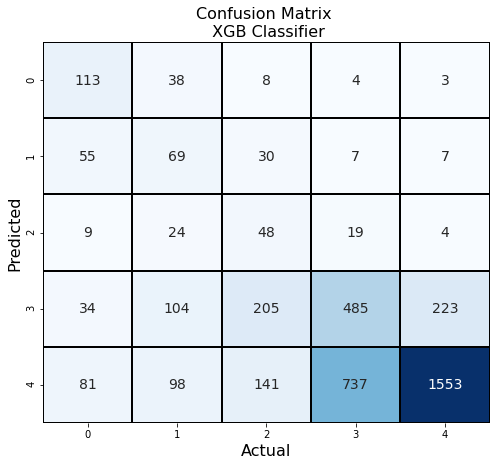

In [ ]:
print("_"*25+"Classification Report"+"_"*25)
print(classification_report(y_pred,y_test,zero_division=0))
print("_"*25+"Evaluation Metrics"+"_"*25)
print("\n")
print("Accuracy: %f" % accuracy_score(y_pred,y_test))
print("Weighted Precision :%f" % precision_score(y_pred,y_test,average="weighted"))
print("MAE :%f" % mean_absolute_error(y_pred,y_test))
print("RMSE :%f" % mean_squared_error(y_pred,y_test,squared=False))


plt.figure(figsize=(8,7))
cm=confusion_matrix(y_pred,y_test)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Blues',cbar=False)

plt.xlabel('Actual',size=16)
plt.ylabel('Predicted',size=16)
plt.title('Confusion Matrix \n XGB Classifier',size=16)
plt.show()

Podemos ver que incluso con GridSearch el resultado del modelo es muy similar (prácticamente el mismo) si quisieramos lograr un modelo que prediga con mayor precisión los ratings bajos podriamos intentar aplciar una función de ganancia que recompense estos mucho más que los demas.

# Machine learning
Ahora intentaremos crear un modelo predictivo con una estrategia diferente.
Utilizaremos Keras que es una biblioteca que utiliza Tensorflow para generar modelos secuenciales (con distinta cantidad de capas) y ademas volveremos a realizar un preprocesamiento de texto pero desde la biblioteca keras_preprocessing

In [ ]:
from keras import layers
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Sequential

In [ ]:
df['Rating'] = df.apply(lambda x: x['Rating']-1 , axis=1)

In [ ]:
data = df.Review
labels = df.Rating

In [ ]:
tokenizer = Tokenizer(num_words= 10000 )
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
word_index = tokenizer.word_index
data = pad_sequences(sequences)

In [ ]:
# Convertimos la columna de ratings a columnas dummies
labels = np.asarray(labels)
labelsCategories = len(np.unique(labels))
labels = to_categorical(labels, labelsCategories)

In [ ]:
# mezclamos los datos
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [ ]:
X_train = data[:19000]
y_train = labels[:19000]
X_test = data[19000:]
y_test = labels[19000:]

In [ ]:
# estos números son por heuristicas, input dim espera el tamaño del vocabulario (aproximado) + 1
inputDim = 10000 + 1
# input lenght = tamaño de cada registro del dataset
inputLength = len(X_train[0])

## Entrenamiento del modelo

In [ ]:
# utilizaremos un modelo secuencial con dos capas convolucionales y una capa densa (con activacion softmax)
model = Sequential()
model.add(layers.Embedding(inputDim, 128, input_length=inputLength))
model.add(layers.Conv1D(64, 7, activation='relu'))
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(64, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation="softmax"))

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Entrenamos el modelo
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.3)

Epoch 1/10
104/104 [==============================] - 11s 104ms/step - loss: 1.1512 - accuracy: 0.4946 - val_loss: 0.9422 - val_accuracy: 0.5768
Epoch 2/10
104/104 [==============================] - 11s 102ms/step - loss: 0.8069 - accuracy: 0.6395 - val_loss: 0.8362 - val_accuracy: 0.6360
Epoch 3/10
104/104 [==============================] - 11s 102ms/step - loss: 0.6775 - accuracy: 0.7098 - val_loss: 0.8607 - val_accuracy: 0.6361
Epoch 4/10
104/104 [==============================] - 11s 102ms/step - loss: 0.5739 - accuracy: 0.7655 - val_loss: 0.8917 - val_accuracy: 0.6304
Epoch 5/10
104/104 [==============================] - 11s 102ms/step - loss: 0.4798 - accuracy: 0.8141 - val_loss: 0.9659 - val_accuracy: 0.6186
Epoch 6/10
104/104 [==============================] - 11s 102ms/step - loss: 0.3963 - accuracy: 0.8556 - val_loss: 1.0749 - val_accuracy: 0.5979
Epoch 7/10
104/104 [==============================] - 11s 101ms/step - loss: 0.3088 - accuracy: 0.8941 - val_loss: 1.1868 - val_ac

In [ ]:
#Evaluamos la perdida del modelo y su presicion con el conjunto de test
print(f'Model loss(1) and accuracy(2): {model.evaluate(X_test, y_test)}')

47/47 [==============================] - 0s 10ms/step - loss: 1.6500 - accuracy: 0.5889
Model loss(1) and accuracy(2): [1.6499515771865845, 0.5888665318489075]


In [ ]:
# Guardamos las metricas del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# Graficamos con with Plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
epochs = range(1, 10 + 1)

fig = make_subplots(rows=2, cols=1, subplot_titles=('Loss', 'Accuracy'))

fig.add_trace(
    go.Scatter(x=list(epochs), y=loss, mode='lines+markers', name='Training loss'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=list(epochs), y=val_loss, mode='lines+markers', name='Validation loss'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=list(epochs), y=acc, mode='lines+markers', name='Training accuracy'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=list(epochs), y=val_acc, mode='lines+markers', name='Validation accuracy'),
    row=2, col=1
)

fig.show()

Este gráfico nos muestra que el modelo comenzo a overfittear, y que a partir de la segunda iteración ya pierde poder predictivo.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max')

history2 = model.fit(X_train,
                    y_train,
                    epochs=40,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[es])

Epoch 1/40
119/119 [==============================] - 11s 96ms/step - loss: 0.2476 - accuracy: 0.9366 - val_loss: 1.3650 - val_accuracy: 0.6034
Epoch 2/40
119/119 [==============================] - 11s 96ms/step - loss: 0.1405 - accuracy: 0.9629 - val_loss: 1.4663 - val_accuracy: 0.5921


In [ ]:
#Evaluamos la presicion del este modelo
print(f'Model loss(1) and accuracy(2): {model.evaluate(X_test, y_test)}')

47/47 [==============================] - 0s 10ms/step - loss: 1.4446 - accuracy: 0.5815
Model loss(1) and accuracy(2): [1.4446481466293335, 0.5814889073371887]


Vemos que el modelo tiene menos perdida y una presicion similar en solo 2 "epochs", de esta forma prevenimos que el modelo entrene de más perdiendo asi poder predictivo (lo que se conoce comunmente como overfit).

# Balanceo del dataset
En vista de que los modelos comparten una capacidad predictiva similar, vamos a intentar entrenar un modelo LDA pero con un dataset balanceado.\
Ya que con estos modelos entrenados con un dataset desbalanceado podremos predecir con mayor precisión puntajes de 5 estrellas pero esa precision empeora para ratings más bajos.

<AxesSubplot:xlabel='Rating', ylabel='count'>

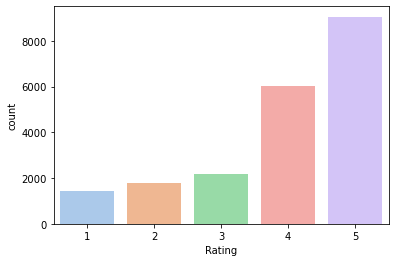

In [ ]:
df = pd.read_csv('https://github.com/pokengineer/rawdata/blob/main/tripadvisor_hotel_reviews.csv?raw=true')
sns.countplot(x='Rating', data=df,  palette="pastel")

In [ ]:
print(df['Rating'].value_counts(normalize = False))

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64


Como podemos ver contamos con menos de 1500 reseñas de 1 estrella y con más de 9000 reseñas de 5 estrellas.\
Existen varias estrategias para afrontar un dataset desbalanceado, y comunmente en este caso intentariamos conseguir más datos, ya que con más datos siempre se podrá conseguir un modelo con mejor poder predictivo.\
Otra estrategia posible será la generación de reseñas artificiales, pero como contamos con tan pocos datos, podemos suponer que estas reseñas van a resultar casi identicas a las que ya tenemos, ademas el metodo de generacion de reseñas implica un clustering de las reseñas que queremos multiplicar y esta es una tarea que se escapa de las posibilidades de este trabajo.\
Finalmente otra estrategia para trabajar con datasets desbalanceados sería eliminar algunos indices del dataset y trabajar asi con un dataset más pequeño pero balanceado.

In [ ]:
df[df['Rating']==1].count()

Review    1421
Rating    1421
dtype: int64

In [ ]:
remove_n = 7000
drop_indices = np.random.choice(df[df['Rating']==5].index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
remove_n = 4000
drop_indices = np.random.choice(df[df['Rating']==4].index, remove_n, replace=False)
df_subset = df_subset.drop(drop_indices)

<AxesSubplot:xlabel='Rating', ylabel='count'>

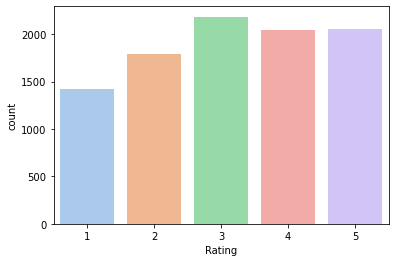

In [ ]:
sns.countplot(x='Rating', data=df_subset,  palette="pastel")

Ahora contamos con un set de datos de aproximadamente 9000 elementos.
Volvemos a ejecutar las rutinas de pre-procesamiento de texto y entrenamiento del modelo.

In [ ]:
docs= np.array(df_subset['Review'])
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()
        docs[idx] = tokenizer.tokenize(docs[idx]) 

    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

docs = docs_preprocessor(docs)

In [ ]:
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

In [ ]:
# Creamos un diccionario con los tokens de docs.
dictionary = Dictionary(docs)
print('Cantidad de palabras distintas en el diccionario:', len(dictionary))

# filtramos las palabras que aparezcan menos de 10 veces o en más del 20% del documento
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Cantidad de palabtas distintas luego de remover las más raras y las más comunes:', len(dictionary))

corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Cantidad de tokens únicos: %d' % len(dictionary))
print('Cantidad de documentos: %d' % len(corpus))

Cantidad de palabras distintas en el diccionario: 34402
Cantidad de palabtas distintas luego de remover las más raras y las más comunes: 7463
Cantidad de tokens únicos: 7463
Cantidad de documentos: 9491


In [ ]:
num_topics = 10
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  
temp = dictionary[0] 
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every,random_state=12)

Wall time: 2min 29s


In [ ]:
pyLDAvis.gensim.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.165356  0.032838       1        1  21.698585
4     -0.187732  0.038520       2        1  15.034879
8     -0.171259  0.110165       3        1  14.614539
9     -0.038036 -0.200038       4        1  13.033139
5     -0.051787 -0.138382       5        1   9.873986
6     -0.001236  0.006240       6        1   7.642680
0     -0.037972  0.296475       7        1   7.440910
1      0.047727 -0.274479       8        1   5.507680
2      0.325938  0.110984       9        1   3.000787
7      0.279712  0.017678      10        1   2.152816, topic_info=                Term         Freq        Total Category  logprob  loglift
3595          resort  4770.000000  4770.000000  Default  30.0000  30.0000
6348      punta_cana  2287.000000  2287.000000  Default  29.0000  29.0000
656   great_location  2607.000000  2607.000000  Default  28.0000  28.0000
283   staff_friendly  2481.000000  2481.000000  Default  27.0000  27.0000
446       didn__ç_é_  1267.000000  1267.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
1061        boutique   157.330959   190.912991  Topic10  -4.7428   3.6449
4862            euro   377.010657   737.172154  Topic10  -3.8689   3.1678
76            hilton   198.002239   336.085559  Topic10  -4.5129   3.3093
922         pressure   139.938918   211.306317  Topic10  -4.8600   3.4263
701           center   149.711403   515.690899  Topic10  -4.7925   2.6016

[542 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
294       2  0.023941      access
294       4  0.323836      access
294       8  0.651452      access
3942      1  0.998996    activity
1435      3  0.995532     advance
...     ...       ...         ...
599       3  0.045772        year
599       4  0.061264        year
599       6  0.223931        year
599       7  0.107740        year
5798      9  0.997737  you__ç_éèe

[1004 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 9, 10, 6, 7, 1, 2, 3, 8])

In [ ]:
from sklearn.model_selection import train_test_split

X = df_subset['Review']
y = df_subset['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
xgb = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier(objective="multi:softmax",n_estimators=300,learning_rate=0.01))
              ])

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

              precision    recall  f1-score   support

           1       0.55      0.53      0.54       288
           2       0.35      0.37      0.36       345
           3       0.43      0.40      0.41       445
           4       0.36      0.44      0.40       362
           5       0.62      0.56      0.58       459

    accuracy                           0.46      1899
   macro avg       0.46      0.46      0.46      1899
weighted avg       0.47      0.46      0.46      1899



Accuracy: 0.457609
Weighted Precision :0.466609
MAE (error absoluto promedio):0.712480
RMSE (error cuadrado promedio):1.068235


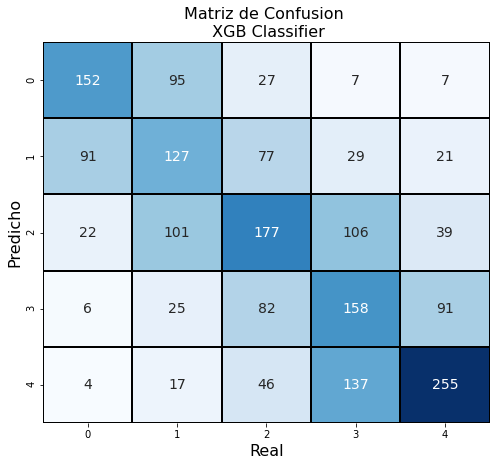

In [ ]:
print(classification_report(y_pred,y_test,zero_division=0))
print("\n")
print("Accuracy: %f" % accuracy_score(y_pred,y_test))
print("Weighted Precision :%f" % precision_score(y_pred,y_test,average="weighted"))
print("MAE (error absoluto promedio):%f" % mean_absolute_error(y_pred,y_test))
print("RMSE (error cuadrado promedio):%f" % mean_squared_error(y_pred,y_test,squared=False))


plt.figure(figsize=(8,7))
cm=confusion_matrix(y_pred,y_test)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Blues',cbar=False)

plt.xlabel('Real',size=16)
plt.ylabel('Predicho',size=16)
plt.title('Matriz de Confusion \n XGB Classifier',size=16)
plt.show()

Vemos que este modelo consigue una presicion bastante más balanceada, de forma gráfica notamos que la matriz identidad posee una buena cantidad de predicciones.\
Ademas vemos que las reseñas de 4 estrellas se confunden con las de 5 y las de 2 con las de 3, que en lineas generales es un error menos extremo que los que encontrabamos en el primer modelo con el set desbalanceado (en el que más de 100 reseñas estaban marcadas como posibles 5 estrellas y en realidad eran 1 estrella).

In [ ]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}
model = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier(objective="multi:softmax",n_estimators=300,learning_rate=0.01))
              ])
gs = GridSearchCV(model, 
                  parameters, 
                  cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=1), #Cross Validation de 3 capas
                  verbose=1,
                  n_jobs=-1)
gs.fit(X_train, y_train)

# Mostramos los mejores resultados obtenidos

print(gs.best_estimator_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 39.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 82.9min finished


[22:11:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_iter, penalty } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.75)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 XGBClassifier(alpha=1e-05, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=6, max_iter=20,
                               min_child_weight=

In [ ]:
y_pred = gs.best_estimator_.predict(X_test)

              precision    recall  f1-score   support

           1       0.56      0.54      0.55       288
           2       0.35      0.37      0.36       340
           3       0.42      0.39      0.40       439
           4       0.38      0.44      0.41       376
           5       0.62      0.56      0.59       456

    accuracy                           0.46      1899
   macro avg       0.46      0.46      0.46      1899
weighted avg       0.47      0.46      0.46      1899



Accuracy: 0.459189
Weighted Precision :0.466960
MAE (error absoluto promedio):0.714060
RMSE (error cuadrado promedio):1.072908


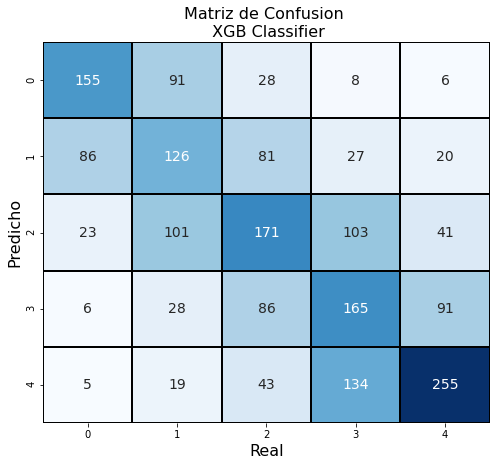

In [ ]:
print(classification_report(y_pred,y_test,zero_division=0))
print("\n")
print("Accuracy: %f" % accuracy_score(y_pred,y_test))
print("Weighted Precision :%f" % precision_score(y_pred,y_test,average="weighted"))
print("MAE (error absoluto promedio):%f" % mean_absolute_error(y_pred,y_test))
print("RMSE (error cuadrado promedio):%f" % mean_squared_error(y_pred,y_test,squared=False))


plt.figure(figsize=(8,7))
cm=confusion_matrix(y_pred,y_test)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Blues',cbar=False)

plt.xlabel('Real',size=16)
plt.ylabel('Predicho',size=16)
plt.title('Matriz de Confusion \n XGB Classifier',size=16)
plt.show()

Cuadro comparativo entre los modelos:
<table style="width:100%">
  <tr>
    <th>Modelo</th>
    <th>Accuracy</th>
    <th>Weighted Precision</th>
    <th>MAE</th>
    <th>RMSE</th>
  </tr>
  <tr>
    <td>Modelo Inicial</td>
    <td>0.52</td>
    <td>0.73</td>
    <td>0.735</td>
    <td>1.26</td>
  </tr>
  <tr>
    <td>Modelo Gridsearch</td>
    <td>0.55</td>
    <td>0.68</td>
    <td>0.64</td>
    <td>1.11</td>
  </tr>
    <tr>
    <td>Modelo Balanceado</td>
    <td>0.47</td>
    <td>0.49</td>
    <td>0.70</td>
    <td>1.08</td>
  </tr>
    <tr>
    <td>Modelo Balanceado GS</td>
    <td>0.46</td>
    <td>0.47</td>
    <td>0.71</td>
    <td>1.07</td>
  </tr>
</table>

# Conclusión
En conclusión aun con un set de datos de menos de 20000 registros y considerablemente desbalanceado logramos obtener predicciones mejores que el azar.\
Estudiamos 3 posibles formas de afrontar el problema, utilizando la biblioteca genism, la biblioteca keras y utilizando la biblioteca genism con una entrada balanceada por nosotros.\
Notamos que en este caso nuestro objetivo era predecir el valor exacto de la reseña, pero sabemos que podriamos haber obtenido mejores resultados si separabamos las reseñas en solo dos categorias "detractores" 1 a 3 estrellas y "promotores" 4 o 5 estrellas, el cual podria ser un estudio similar al realizado. O, si el caso de negocio priorizara reconocer las reseñas negativas para mitigar los detractores se podria haber realizado una función de ganancia para esto al igual que la estudiamos durante el cuatrimestre.